In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn as nn
from collections import deque
from tqdm.notebook import tqdm
import random
import math
from IPython.display import clear_output

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CartPole

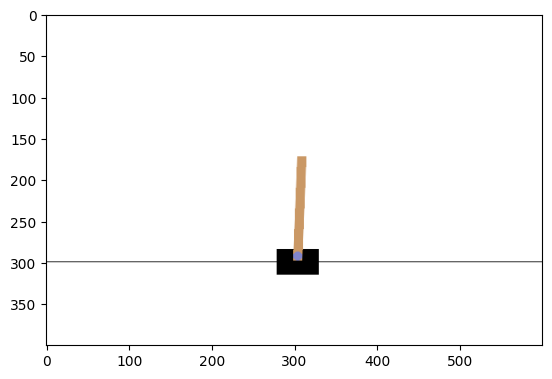

In [3]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())

In [4]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)

In [10]:
class DQN(nn.Module):
    def __init__(self,n_actions,n_states):
        super(DQN,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(n_states,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )
    def forward(self,state):
        action_value = self.f(state)
        return action_value
Q = DQN(2,4).to(device)

In [11]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [7]:
replaybuffer = ReplayBuffer(max_capacity=2000,batch_size=4)
num_games = 1000000
learn_flag = 2000
gamma = 0.9
static_Q = DQN(2,4).to(device)
static_Q.load_state_dict(Q.state_dict())
optimizer = torch.optim.Adam(Q.parameters(),lr=3e-4)
update_weights = 200
epsilon = 1.0
average_game_reward = []
for game in tqdm(range(num_games)):
    state,info = env.reset()
    
    game_reward = 0
    while True:
        action = select_action(state,epsilon=epsilon)
        next_state,reward,done,_,info = env.step(action)
        replaybuffer.add(state,action,reward,next_state,done)
        
        if done:
            break
        state = next_state
        game_reward += reward
        
    average_game_reward.append(game_reward)
    if game % learn_flag == 0:
        for batch in range(len(replaybuffer.buffer)):
            state,action,reward,next_state,done = replaybuffer.get_batch()
            state = torch.from_numpy(state).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward).to(device)
            next_state = torch.from_numpy(next_state).to(device)
            not_done =torch.tensor(1-np.array(done)).to(device)
        
            target = reward + not_done * (gamma * torch.max(static_Q(next_state).detach(),dim=1)[0])
            prediction = Q(state)
            prediction = prediction[range(len(action)),action]
            loss = (target-prediction)**2
            loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % update_weights == 0:
                static_Q.load_state_dict(Q.state_dict())
        epsilon *= 0.8
        epsilon = max(1e-6,epsilon)
        print('average game reward',np.mean(average_game_reward[-100:]))
        print(f'epsilon {epsilon:.2f}')
        if np.mean(average_game_reward[-100:]) > env.spec.reward_threshold:
            print('DONE')
            break

  0%|          | 0/1000000 [00:00<?, ?it/s]

average game reward 19.0
epsilon 0.80
average game reward 17.5
epsilon 0.64
average game reward 24.94
epsilon 0.51
average game reward 42.18
epsilon 0.41
average game reward 175.97
epsilon 0.33
average game reward 254.45
epsilon 0.26
average game reward 365.75
epsilon 0.21
average game reward 448.5
epsilon 0.17
average game reward 376.07
epsilon 0.13
average game reward 255.55
epsilon 0.11
average game reward 278.44
epsilon 0.09
average game reward 100.92
epsilon 0.07
average game reward 133.17
epsilon 0.05
average game reward 444.08
epsilon 0.04
average game reward 496.8
epsilon 0.04
DONE


In [14]:
# env_2 = gym.make('CartPole-v1',render_mode = 'rgb_array')
# env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         action = select_action(state,epsilon=0)
#         next_state,reward,done,_,info = env_2.step(action)
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()

# Atari Pong

In [44]:
from gymnasium.wrappers import AtariPreprocessing

actions Discrete(6)
observation Box(0, 255, (210, 160, 3), uint8)


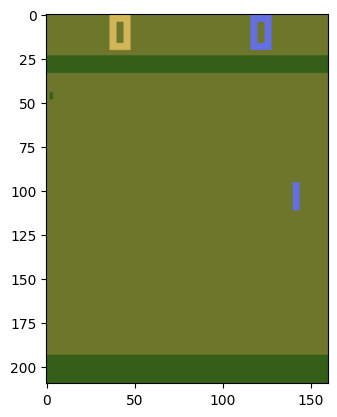

In [45]:
env = gym.make('PongNoFrameskip-v4',render_mode = 'rgb_array')
state,info = env.reset()
print('actions',env.action_space)
print('observation',env.observation_space)
plt.imshow(env.render())
plt.show()

In [46]:
class ConvDQN(nn.Module):
    def __init__(self,n_actions):
        super(ConvDQN,self).__init__()
        self.q = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=8,stride=4),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592,256),
            nn.ReLU(),
            nn.Linear(256,n_actions)
        )
        
    def forward(self,state):
        q_value = self.q(state)
        return q_value

In [47]:
Q = ConvDQN(6).to(device)
env = AtariPreprocessing(env,scale_obs=True,grayscale_newaxis=False,grayscale_obs=True)

In [48]:
def select_action(state,epsilon = 1e-6):
    
    state = torch.from_numpy(state).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [52]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 40000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [53]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [54]:
10000//32


312

In [57]:
def train(Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 1e-4):
    static_Q = ConvDQN(6).to(device)
    static_Q.load_state_dict(Q.state_dict())
    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > 10000:
            s,action,reward,next_state,done = replay_buffer.get_batch()
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward).to(device)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done)).to(device)
            target = reward + not_done * (gamma * torch.max(static_Q(next_state).detach(),dim=1)[0])
            prediction = Q(s)
            prediction = prediction[range(len(action)),action]
            loss = torch.nn.functional.mse_loss(prediction,target,reduction='mean')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-10:]) > 20:
            print('Solved')
            break
        if t % 10000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

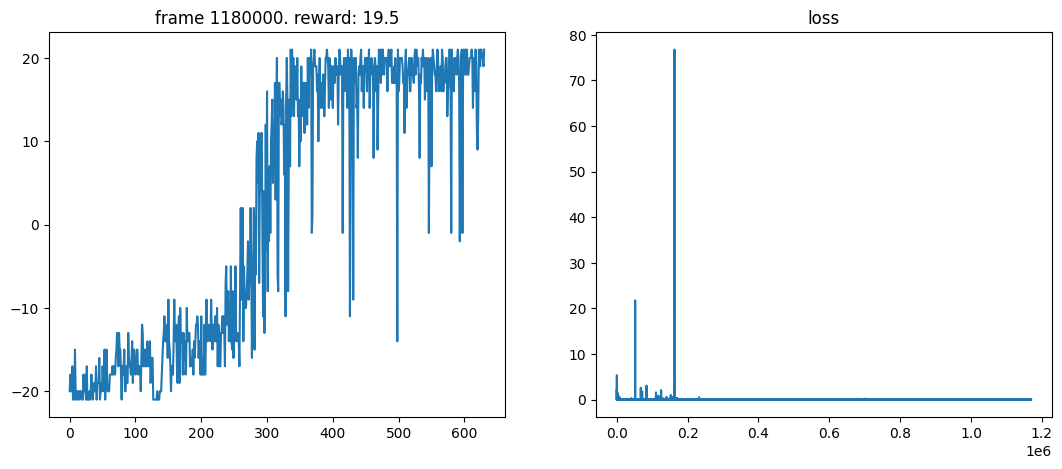

epsilon 0.01
Solved


In [58]:
train(Q,10000000,env,batch_size=32,replay_buffer_size=100000)